آزمایش نهم آزمایشگاه بینایی ماشین: شبکه های عصبی

دانشجو: سیدسعید جزائری

شماره دانشجویی: 98104885

 :را به صورت زیر میسازیم AND مدل پرسپترون یک گیت 

 ![](and.jpg)

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as img
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings 

warnings.filterwarnings('ignore') 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


<function matplotlib.pyplot.show(close=None, block=None)>

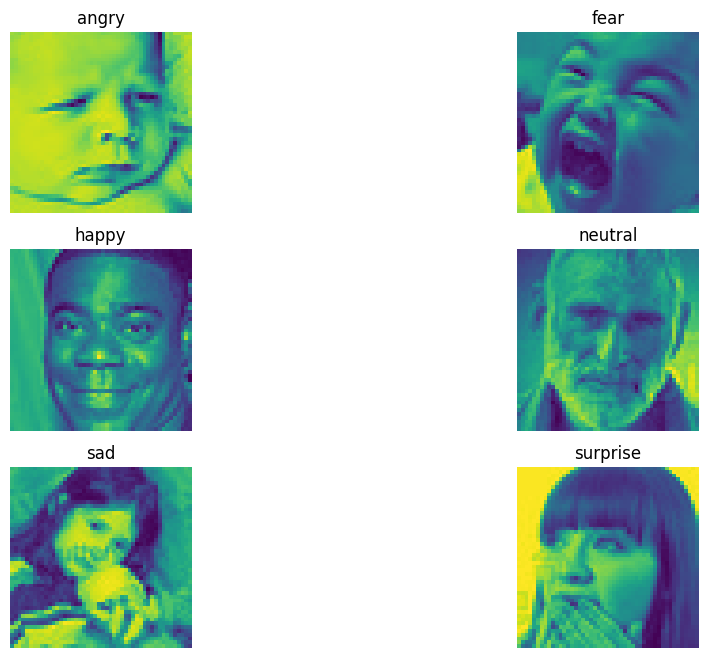

In [8]:
classes = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plt.figure(figsize=(12,8))
for itr, clss in enumerate(classes):
    pic = img.imread(f'./FER-2013/val/{clss}/{clss}.jpg')
    plt.subplot(3,2,itr+1)
    plt.imshow(pic)
    plt.axis('off')
    plt.title(f"{clss}")
plt.show


In [9]:
X_train = []
y_train = []

for itr, clss in enumerate(classes):
    path = './FER-2013/train/' + clss
    pics = os.listdir(path)
    for pic in pics:
        temp = img.imread(path + '/' + pic)
        temp = temp.flatten()
        X_train.append(np.array(temp)/255.0)
        y_train.append(torch.tensor(itr, dtype=torch.long))

X_train = np.array(X_train)
y_train = np.array(y_train)

In [10]:
X_val = []
y_val = []

for itr, clss in enumerate(classes):
    path = './FER-2013/val/' + clss
    pics = os.listdir(path)
    for pic in pics:
        temp = img.imread(path + '/' + pic)
        temp = temp.flatten()
        X_val.append(np.array(temp)/255.0)
        y_val.append(torch.tensor(itr, dtype=torch.long))

X_val = np.array(X_val)
y_val = np.array(y_val)

In [11]:
X_test = []
y_test = []

for itr, clss in enumerate(classes):
    path = './FER-2013/test/' + clss
    pics = os.listdir(path)
    for pic in pics:
        temp = img.imread(path + '/' + pic)
        temp = temp.flatten()
        X_test.append(np.array(temp)/255.0)
        y_test.append(torch.tensor(itr, dtype=torch.long))

X_test = np.array(X_test)
y_test = np.array(y_test)

In [63]:
X_train, X_val, X_test, y_train, y_val, y_test = map(torch.tensor, (X_train, X_val, X_test, y_train, y_val, y_test))


mean = X_train.mean(dim=0) 
std = X_train.std(dim=0) 
X_train = (X_train - mean) / std 
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std



train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64 , shuffle=False)

In [18]:
class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(in_features=48*48, out_features=6)  

    def forward(self, x):
        x = F.softmax(self.fc(x))
        return x


model = SingleLayerNN().to(device)
learning_rate = 0.0001  
weight_decay = 0.001
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


history = {
  'loss': [],
  'val_loss': [],
  'acc': [],
  'val_acc': []
}
for epoch in range(epochs):
    model.train()

    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images.float())
        # print(labels.shape, outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()



    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Accuracy: {train_correct / train_total:.4f} - "
          f"Train Loss: {train_loss / len(train_loader):.4f} - "
          f"Validation Accuracy: {val_correct / val_total:.4f} - "
          f"Validation Loss: {val_loss / len(val_loader):.4f}")
    
    history['acc'].append(train_correct / train_total)
    history['loss'].append(train_loss / len(train_loader))
    history['val_acc'].append(val_correct / val_total)
    history['val_loss'].append(val_loss / len(val_loader))


Epoch 1/50 - Train Accuracy: 0.2961 - Train Loss: 1.7283 - Validation Accuracy: 0.3314 - Validation Loss: 1.6982
Epoch 2/50 - Train Accuracy: 0.3570 - Train Loss: 1.6840 - Validation Accuracy: 0.3678 - Validation Loss: 1.6736
Epoch 3/50 - Train Accuracy: 0.3729 - Train Loss: 1.6668 - Validation Accuracy: 0.3794 - Validation Loss: 1.6620
Epoch 4/50 - Train Accuracy: 0.3826 - Train Loss: 1.6576 - Validation Accuracy: 0.3802 - Validation Loss: 1.6550
Epoch 5/50 - Train Accuracy: 0.3896 - Train Loss: 1.6513 - Validation Accuracy: 0.3876 - Validation Loss: 1.6512
Epoch 6/50 - Train Accuracy: 0.3926 - Train Loss: 1.6461 - Validation Accuracy: 0.3890 - Validation Loss: 1.6484
Epoch 7/50 - Train Accuracy: 0.3954 - Train Loss: 1.6429 - Validation Accuracy: 0.3881 - Validation Loss: 1.6464
Epoch 8/50 - Train Accuracy: 0.3993 - Train Loss: 1.6394 - Validation Accuracy: 0.3935 - Validation Loss: 1.6454
Epoch 9/50 - Train Accuracy: 0.4018 - Train Loss: 1.6365 - Validation Accuracy: 0.3952 - Validat

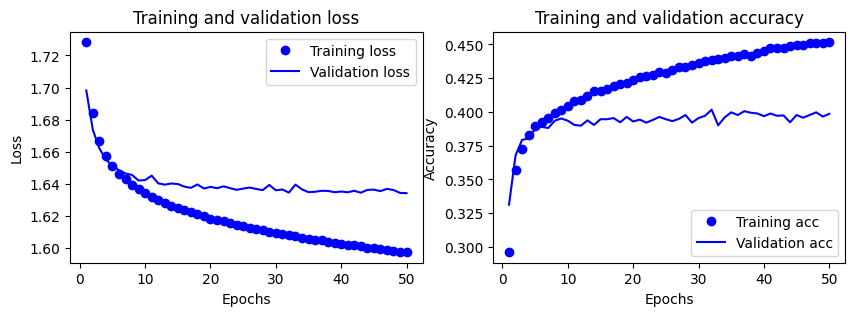

In [19]:
def visualize_loss_and_acc(history_dict):
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

visualize_loss_and_acc(history)



ناشی از همین است. Valid  و  Train  انجام داده ایم و این فاصله میان  Train را به معنای کسر میانگین از داده ها و تقسیم به واریانس، بر اساس داده های Transform دقت کنید که ما عملیات 

Test set accuracy = 34.729691480328334 %


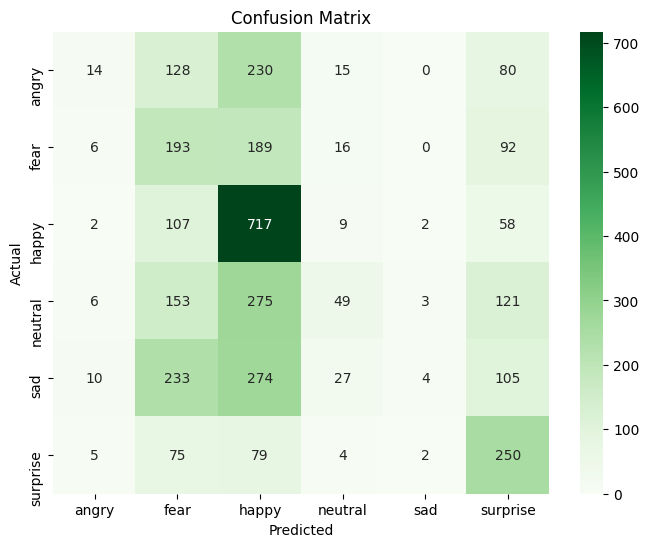

In [55]:
test_acc=0
model.eval()

y_predc = []

with torch.no_grad():
	for i, (images, labels) in enumerate(test_loader):

		images = images.to(device)
		y_true = labels.to(device)

		outputs = model(images.float())

		_, y_pred = torch.max(outputs.data, 1)

		y_pred2 = y_pred.cpu().numpy().tolist()
		y_predc = y_predc + y_pred2

		test_acc += (y_pred == y_true).sum().item()

	print(f"Test set accuracy = {100 * test_acc / len(test_dataset)} %")

conf_mat = confusion_matrix(y_test.to('cpu'), y_predc)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

واضح است که یک مدل شبکه عصبی تک لایه، مخصوصا در حالتی که تصاویر را به بردار های تک بعدی با تعداد ویژگی برابر با تعداد پیکسل ها عملکرد بینظیری نخواهد داشت.

به دقت حدود 40 رسیده ایم که از حالت رندوم آن یعنی حدود 17 درصد مقدار معقولی بهتر است. epoch در این حالت بعد از 50 مرتبه  

In [56]:
class MultiLayerNN(nn.Module):
    def __init__(self):
        super(MultiLayerNN, self).__init__()
        self.fc1 = nn.Linear(in_features=48*48, out_features=256)  
        self.fc2 = nn.Linear(in_features=256, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=6)

    

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x))
        return x

In [64]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


model = MultiLayerNN().to(device)
learning_rate = 0.0001  
weight_decay = 0.001
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


history = {
  'loss': [],
  'val_loss': [],
  'acc': [],
  'val_acc': []
}
for epoch in range(epochs):
    model.train()

    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images.float())
        # print(labels.shape, outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()



    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Accuracy: {train_correct / train_total:.4f} - "
          f"Train Loss: {train_loss / len(train_loader):.4f} - "
          f"Validation Accuracy: {val_correct / val_total:.4f} - "
          f"Validation Loss: {val_loss / len(val_loader):.4f}")
    
    history['acc'].append(train_correct / train_total)
    history['loss'].append(train_loss / len(train_loader))
    history['val_acc'].append(val_correct / val_total)
    history['val_loss'].append(val_loss / len(val_loader))

Epoch 1/50 - Train Accuracy: 0.3208 - Train Loss: 1.7024 - Validation Accuracy: 0.3633 - Validation Loss: 1.6660
Epoch 2/50 - Train Accuracy: 0.3799 - Train Loss: 1.6493 - Validation Accuracy: 0.3856 - Validation Loss: 1.6423
Epoch 3/50 - Train Accuracy: 0.3982 - Train Loss: 1.6331 - Validation Accuracy: 0.3989 - Validation Loss: 1.6327
Epoch 4/50 - Train Accuracy: 0.4142 - Train Loss: 1.6196 - Validation Accuracy: 0.3963 - Validation Loss: 1.6309
Epoch 5/50 - Train Accuracy: 0.4274 - Train Loss: 1.6086 - Validation Accuracy: 0.4028 - Validation Loss: 1.6270
Epoch 6/50 - Train Accuracy: 0.4409 - Train Loss: 1.5970 - Validation Accuracy: 0.4059 - Validation Loss: 1.6240
Epoch 7/50 - Train Accuracy: 0.4530 - Train Loss: 1.5866 - Validation Accuracy: 0.4113 - Validation Loss: 1.6180
Epoch 8/50 - Train Accuracy: 0.4609 - Train Loss: 1.5786 - Validation Accuracy: 0.4172 - Validation Loss: 1.6168
Epoch 9/50 - Train Accuracy: 0.4733 - Train Loss: 1.5684 - Validation Accuracy: 0.4161 - Validat

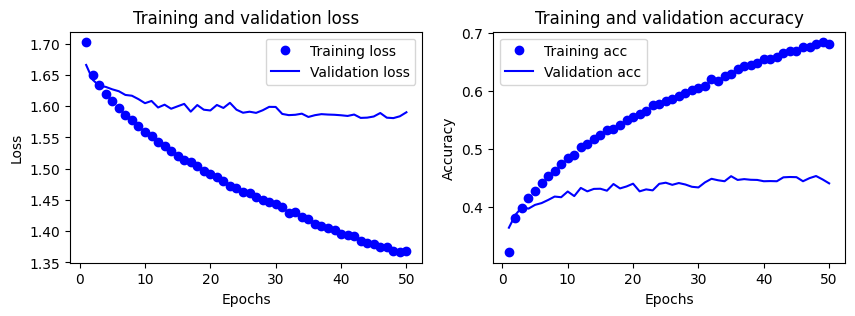

Test set accuracy = 32.46532691763374 %


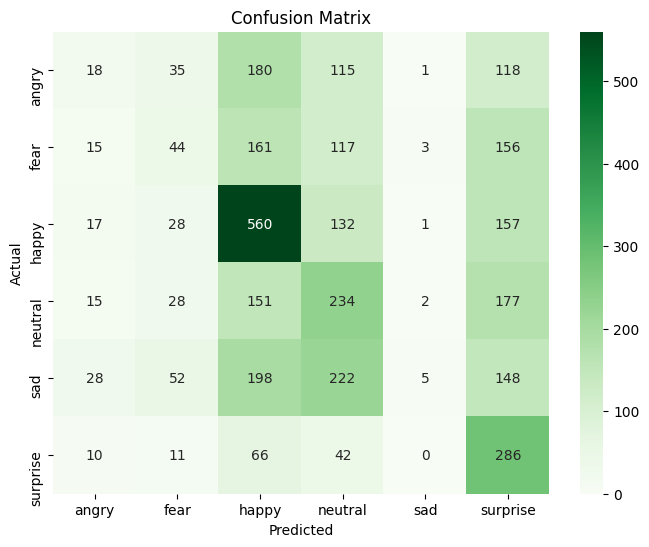

In [65]:
visualize_loss_and_acc(history)


test_acc=0
model.eval()
X_test, y_test = map(torch.tensor, (X_test, y_test))
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset) , shuffle=False)

with torch.no_grad():
	for i, (images, labels) in enumerate(test_loader):

		images = images.to(device)
		y_true = labels.to(device)

		outputs = model(images.float())

		_, y_pred = torch.max(outputs.data, 1)

		test_acc += (y_pred == y_true).sum().item()

	print(f"Test set accuracy = {100 * test_acc / len(test_dataset)} %")


conf_mat = confusion_matrix(y_test.to('cpu'), y_pred.to('cpu'))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

.مشاهده نمیشود Test و  Validation افزایش یافته و به همان میزان خطا کم شده است، اثر مشهودی روی دقت مدل بر روی داده های  Train واضح است با اضافه کردن لایه های مخفی، علی رغم اینکه دقت مدل برروی داده های 

شدن مدل میشود. Overfit به نوعی میتوان گفت اضافه کردن بی مورد لایه های مخفی به مدل، باعث 

### بررسی تغییر پارامترها: Learning Rate

In [42]:
learning_rates = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
history = {
      'train_acc': [],
      'val_acc': [],
      'test_acc': []
    }

train_acc_epochs = []

for lr in learning_rates:
    model = SingleLayerNN().to(device)
    weight_decay = 0.001
    epochs = 40
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    accs = []

    for epoch in range(epochs):
        model.train()

        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images.float())
            # print(labels.shape, outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        accs.append(train_correct / train_total)


        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

    
    
    history['train_acc'].append(train_correct / train_total)
    history['val_acc'].append(val_correct / val_total)
    history['test_acc'].append(test_correct / test_total)
    train_acc_epochs.append(accs)
    

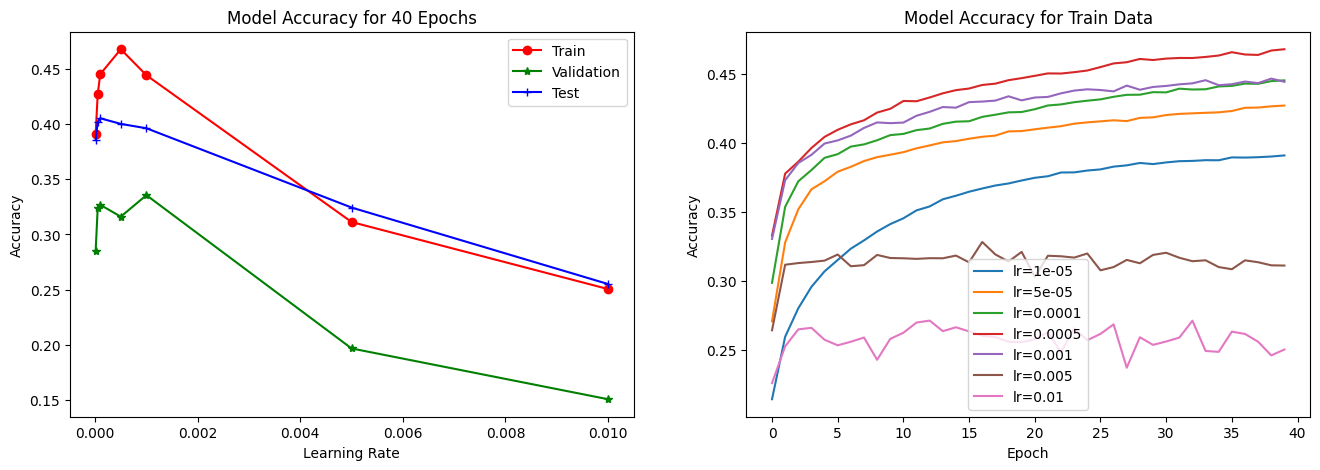

In [51]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.plot(learning_rates, history['train_acc'], '-o', color='r', label='Train') 
plt.plot(learning_rates, history['val_acc'], '-*', color='g', label='Validation') 
plt.plot(learning_rates, history['test_acc'], '-+', color='b', label='Test')

plt.xlabel("Learning Rate") 
plt.ylabel("Accuracy") 
plt.title("Model Accuracy for 40 Epochs") 

plt.legend() 


plt.subplot(1,2,2)
for itr, curve in enumerate(train_acc_epochs):
    plt.plot(range(epochs), curve, label=f'lr={learning_rates[itr]}')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy") 
plt.title("Model Accuracy for Train Data") 

plt.legend() 

plt.show() 


### :به شرح زیر است Learning Rate بابررسی دو دسته منحنی فوق واضح است اثرات ابرپارامتر

#### 1) دقت مدل
بر دقت نهایی مدل اثرگذار است. به این معنا که این متغیر نباید چندان بزرگ انتخاب شود چرا که بر تغییر مقدار وزن نورون ها به صورت نمایی اثر میگذارد Learning Rate از منحنی سمت چپ مشخص است که مقدار عددی 

#### 2) سرعت همگرا شدن
باعث همگرایی سریعتر میشود. در مقابل مقدار کم این ابرپارامتر، منجر میشود که همگرا شدن بیشتر طول بکشد. بدیهی است که علی رغم اینکه با بزرگ انتخاب شدن این ابرپارامتر زودتر به همگرایی میرسیم، اما دقت مدل مناسب نیست و پایداری مناسب رعایت نشده است Learning Rate از منحنی های سمت راست و تغییرات آن ها در راستای ایپاک، مشخص است که مقادیر بزرگتر

#### 3) Underfitting اثر بر میزان 
 با   بررسی منحنی های سمت چپ میبینیم که با زیاد کردن این ابرپارامتر، مدل حتی رفتار داده های آموزش را نیز به خوبی یاد نگرفته است و دقت آن با زیاد شدن این ابرپارامتر، کاهش میابد. بنابراین برای جلوگیری از آندرفیت شدن نباید این ابرپارامتر بی توجه بزرگ انتخاب شود   

#### 4) گذر از بهینه یهای محلی
 .بیشتر است lr=0.01 و lr=0.00001 از هر دو حالت lr=0.0005 با بررسی منحنی های سمت راست میبینم که دقت مدل به ازای 

 یعنی بسیار بزرگ انتخاب شدن آن یا بسیار کوچک انتخاب شدن آن منجر میشود مدل در بهینه های مینیمم محلی یا ماکسیمم محلی گیر کند و نتواند با گرادیان به سمت بهینه گلوبال حرکت کند. بنابراین باید این متغیر معقول و متعادل انتخاب شود

### بررسی تغییر پارامترها: Optimizer

In [66]:
optimizers = ['SGD', 'Adam', 'RMSprop', 'Adagrad']
history = {
      'train_acc': [],
      'val_acc': [],
      'test_acc': []
    }

train_acc_epochs = []

for opt in optimizers:
    model = SingleLayerNN().to(device)
    weight_decay = 0.001
    epochs = 40
    criterion = nn.CrossEntropyLoss()
    if opt=='SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)
    elif opt=='Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
    elif opt=='RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=weight_decay)
    elif opt=='Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=weight_decay)
        
    accs = []

    for epoch in range(epochs):
        model.train()

        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images.float())
            # print(labels.shape, outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        accs.append(train_correct / train_total)


        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

    
    
    history['train_acc'].append(train_correct / train_total)
    history['val_acc'].append(val_correct / val_total)
    history['test_acc'].append(test_correct / test_total)
    train_acc_epochs.append(accs)
    

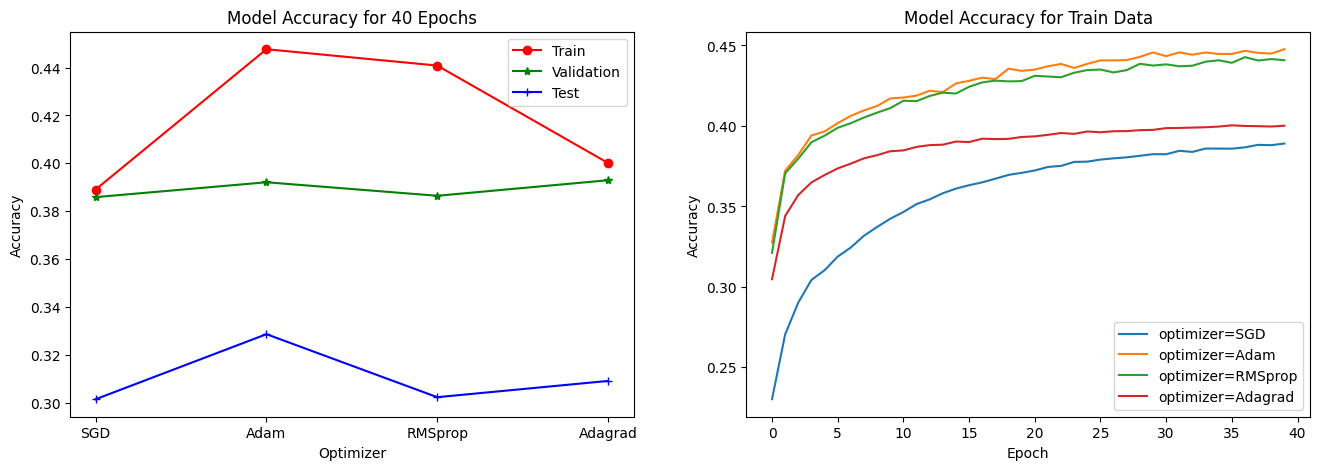

In [67]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.plot([0, 1, 2, 3], history['train_acc'], '-o', color='r', label='Train') 
plt.plot([0, 1, 2, 3], history['val_acc'], '-*', color='g', label='Validation') 
plt.plot([0, 1, 2, 3], history['test_acc'], '-+', color='b', label='Test')

plt.xlabel("Optimizer") 
plt.ylabel("Accuracy") 
plt.title("Model Accuracy for 40 Epochs") 
plt.xticks([0, 1, 2, 3], optimizers)

plt.legend() 


plt.subplot(1,2,2)
for itr, curve in enumerate(train_acc_epochs):
    plt.plot(range(epochs), curve, label=f'optimizer={optimizers[itr]}')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy") 
plt.title("Model Accuracy for Train Data") 

plt.legend() 

plt.show() 

### :به شرح زیر است Optimizer  بابررسی دو دسته منحنی فوق واضح است اثرات ابرپارامتر

#### بدیهی است در کاربرد های مختلف و نوع داده ای که برروی آن قرار است آموزش صورت بگیرد،اپتیمایزر متفاوت خواهد بود و البته اثر زیادی دارد. بنابراین لازم است بنابه شرایط از اپتیمایزر مناسب استفاده کنیم. ولی کلیت توضیحات به شرح زیر است  
- SGD: الگوریتم ساده مبتنی بر گرادیان است و پارامتر ها را برمبنای این روش آپدیت میکند. چون از پیچیدگی محاسباتی کمتری برخوردار است سرعت بالاتری دارد اما همانوطر که در هر دو شکل سمت چپ و راست واضح است، منجر به دقت کمتری خواهد شد

- Adam: متداول ترین نوع اپتیمایزر است و از ترکیب ایده ی مومنتوم و «آر ام اس پروپ» تشکیل شده است. بر اساس تاریخچه ای که از گرادیان ها ذخیره میکند به آپدیت پارامتر ها مییپردازد و برای کاربردهایی به دیتاست بزرگ مناسب است. بنابراین مزیت مومنتم و «آر ام اس پروپ» را هم زمان دارد و برای انواع گوناگونی از داده ها مناسب است. 
در مقابل در حالات کم دیتاست، احتمال اورفیتینگ بیشتر دارد و همینطور از منابع مموری بیشتری استفاده میکند

- RMSpro: در این روش با تغییر ابرپارامتر «لرنینگ ریت» با تقسیم آن به میانگین خطای ام اس ای گرادیان ها، به صورت آداپتیو به آپدیت پارامتر ها میپردازد.
بنابراین این آداپتیو بودن برای کیس های با مدل چند لایه آن را مناسب کرده است. همینطور برای انواع متنوعی از داده ها بسیار پاسخگوست و میبینیم در کیس ما نیز بیشترین دقت را در هر سه دسته آموزش، ولیدیشن و تست داشته است.
در مقابل نرخ همگرا شدن بیشتری دارد و استعداد بیشتری برای واگرا شدن دارد که در شکل سمت راست نیز مشخص است

- Adagrad: با گذر دادن یک پنجره از گرادیان ها به محاسبه مومنتوم دوم گرادیان میپردازد و به این شیوه تصمیم به آپدیت پارامتر ها میکند. بنابراین به طور انطباقی آپدیت پارامتر ها صورت میگیرد که «پارامتر لرنینگ ریت» را در مرور زمان کاهش میدهد

مموری کمی لازم دارد و در عوض چون به پارامتر «لرنینگ ریت» دست میزند ممکن است عوارض ناشی از کوچک بودن آن را به دنبال داشته باشد


منبع: https://medium.com/@ahmadsabry678/various-types-of-optimizers-in-deep-learning-advantages-and-disadvantages-for-each-type-ed42ba1609d

### بررسی تغییر پارامترها: Batch Size

In [54]:
BatchSizes = [16, 32, 64, 128]
history = {
      'train_acc': [],
      'val_acc': [],
      'test_acc': []
    }

train_acc_epochs = []

for bs in BatchSizes:
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

    model = SingleLayerNN().to(device)
    weight_decay = 0.001
    epochs = 40
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
    accs = []

    for epoch in range(epochs):
        model.train()

        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images.float())
            # print(labels.shape, outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        accs.append(train_correct / train_total)


        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

    
    
    history['train_acc'].append(train_correct / train_total)
    history['val_acc'].append(val_correct / val_total)
    history['test_acc'].append(test_correct / test_total)
    train_acc_epochs.append(accs)
    

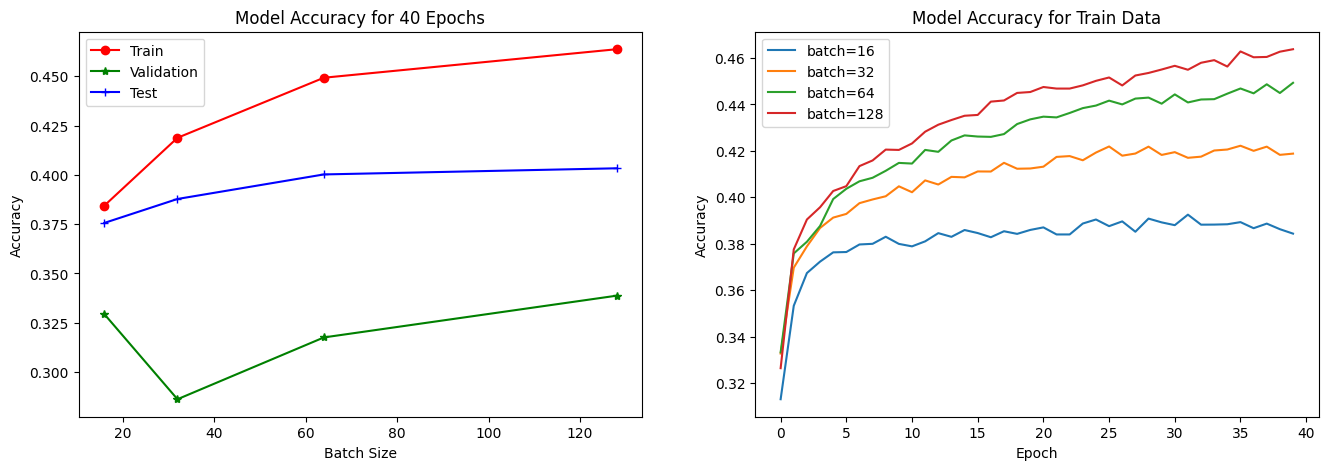

In [55]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.plot(BatchSizes, history['train_acc'], '-o', color='r', label='Train') 
plt.plot(BatchSizes, history['val_acc'], '-*', color='g', label='Validation') 
plt.plot(BatchSizes, history['test_acc'], '-+', color='b', label='Test')

plt.xlabel("Batch Size") 
plt.ylabel("Accuracy") 
plt.title("Model Accuracy for 40 Epochs") 

plt.legend() 


plt.subplot(1,2,2)
for itr, curve in enumerate(train_acc_epochs):
    plt.plot(range(epochs), curve, label=f'batch={BatchSizes[itr]}')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy") 
plt.title("Model Accuracy for Train Data") 

plt.legend() 

plt.show() 


### :به شرح زیر است Batch Size  بابررسی دو دسته منحنی فوق واضح است اثرات ابرپارامتر

#### 1) دقت مدل:
از هردودسته نمودار های فوق واضح است که بزرگتر بودن «بچ سایز» منجر به دقت بیشتری در مدل نهایی میشود

#### 2)سرعت همگرایی:
واضح است که بچ سایز های کوچکتر هرچند به دقت کمتر، اما سریعتر همگرا شده اند. بنابراین سرعت همگرایی با «بچ سایز» رابطه ی عکس دارد

#### 3) میزان استفاده از منابع:
چون داده ها به اندازه «بچ سایز» در هر مرحله در مموری لود میشوند، سیستم هایی که سخت افزار ضعیف تری دارند انتخاب «بچ سایز» کوچکتر به آن ها کمک میکند تا بتوانند فرایند آموزش را بدون مشکل انجام دهند. بنابراین بر میزان استفاده از مموری اثرگذار است

#### 4) عمومیت آموزش
اگر «بچ سایز» را کوچک انتخاب کنیم، چون ضرایب و پارامتر ها تعداد دفعات بیشتری آپدیت میشوند احتمالا از عمومیت بالاتری برخوردار هستند و انتظار نزدیکی بیشتری میان دقت تست و ترین داریم که در شکل بالا سمت چپ هم واضح است. از طرفی اگر «بچ سایز» بزرگ باشد احتمال اورفیتینگ را افزایش میدهد


### بررسی تغییر پارامترها: Number of Epoch

In [62]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

NumEpochs = [1, 2, 5, 10, 20, 35, 50, 70]
history = {
      'train_acc': [],
      'val_acc': [],
      'test_acc': []
    }

train_acc_epochs = []

for epc in NumEpochs:
    
    model = SingleLayerNN().to(device)
    weight_decay = 0.001
    epochs = epc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
    accs = []

    for epoch in range(epochs):
        model.train()

        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images.float())
            # print(labels.shape, outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        accs.append(train_correct / train_total)


        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

    
    
    history['train_acc'].append(train_correct / train_total)
    history['val_acc'].append(val_correct / val_total)
    history['test_acc'].append(test_correct / test_total)
    train_acc_epochs.append(accs)
    

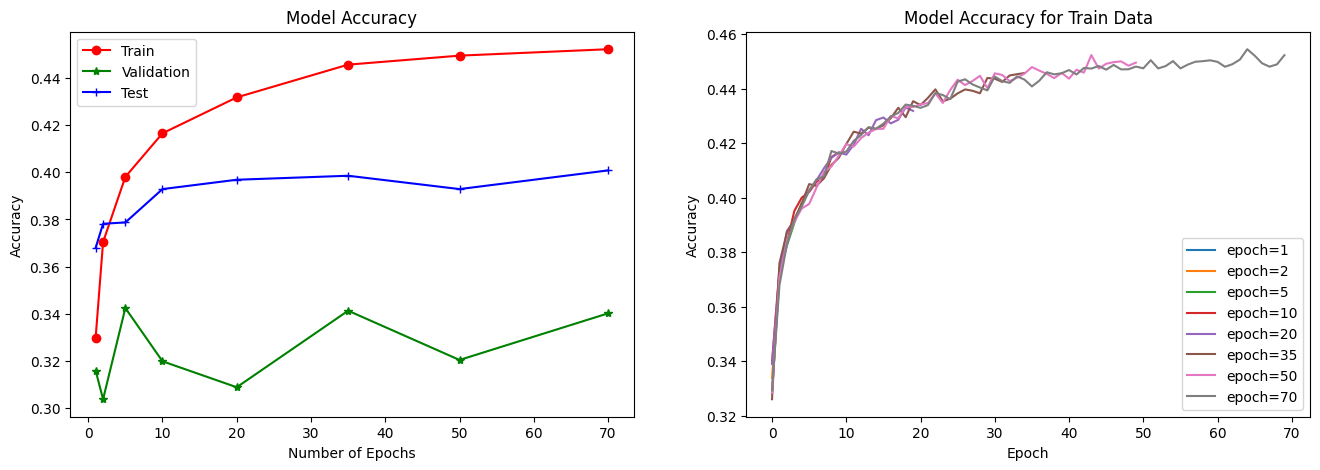

In [63]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.plot(NumEpochs, history['train_acc'], '-o', color='r', label='Train') 
plt.plot(NumEpochs, history['val_acc'], '-*', color='g', label='Validation') 
plt.plot(NumEpochs, history['test_acc'], '-+', color='b', label='Test')

plt.xlabel("Number of Epochs") 
plt.ylabel("Accuracy") 
plt.title("Model Accuracy") 

plt.legend() 


plt.subplot(1,2,2)
for itr, curve in enumerate(train_acc_epochs):
    plt.plot(range(len(curve)), curve, label=f'epoch={NumEpochs[itr]}')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy") 
plt.title("Model Accuracy for Train Data") 

plt.legend() 

plt.show() 


### :به شرح زیر است Number of Epochs  بابررسی دو دسته منحنی فوق واضح است اثرات ابرپارامتر

#### 1) آندرفیتینگ و اورفیتینگ:
مهم ترین اثرگذاری تعداد «ایپاک» اثرگذاری بر دو مفهوم آندرفیتینگ و اورفیتینگ است. همانطور که از شکل بالا سمت چپ هم پیداست، تعداد ایپاک کم منجر به آندرفیتینگ میشود به نحوی که دقت مدل برروی داده های تست از داده های آموزش بیشتر است. از طرف دیگر تعداد ایپاک زیاد منجر به اورفیتینگ میشود به نحوی که دقت مدل برای داده های آموزش بیشتر شده است ولی دقت برای داده های تست تقریبا ثابت مانده است

#### 2) مصرف منابع پردازشی
بدیهی است تعداد ایپاک بیشتر، به زمان بیشتری برای آموزش شبکه و مدل لازم دارد و بنابراین منابع سخت افزاری از جمله پردازنده مرکزی و پردازنده گرافیکی و مموری را بیشتر تحت فشار قرار میدهد

#### 3) همگرایی
همانطور که از دسته منحنی های شکل سمت راست پیداست، مطابق انتظار این منحنی ها با هم همپوشانی زیادی دارند و رفتار آن ها به صورت تکه خطی مشابه هم است. اما برای ایپاک های کم مدل به همگرایی نرسیده و مشتق آن همچنان زیاد است اما برای ایپاک های بزرگ میبینیم که مدل تقریبا به همگرایی و ماکسیمم دقت خود رسیده است

#### 4) ابزار دیباگ به کمک ولیدیشن
با توجه به اینکه میتوان فرایند یادگیری را پس از هر مرحله ایپاک متوقف کرد و در فرصت بعدی از ادامه ی آن یادگیری را ادامه داد، تعداد ایپاک این قابلیت را میدهد که 
آموزش مدل را برای ایپاک های بیشتر ذخیره کرد و بعدا بیشتر یاد داد. برای اینکار باید یک فایل «چک پوینتس» از مدل ذخیره کرد